Consider the task of predicting points in a linear relationship.

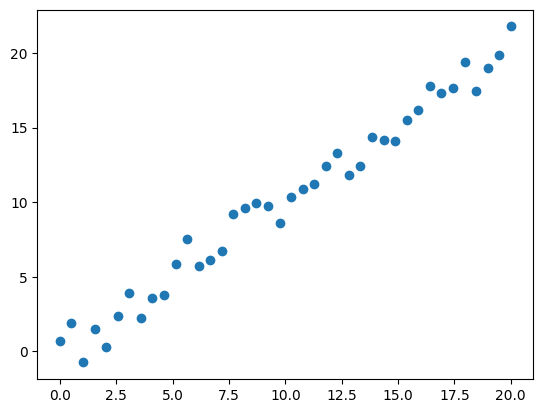

In [1]:
from fastai.tabular.all import *

x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

We first unsqueeze `x_lin` into the shape expected by `sklearn` for the records of non-target features.

In [2]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

The following is another way to achieve the same transformation, and it can put the dimensions in arbitraty order, as illustrated below.

In [3]:
x_lin[None, :, None, None].shape

torch.Size([1, 40, 1, 1])

Back to the task, we fit a random forest on the first 30 of 40 points (these are the lower x-valued points)

In [4]:
from sklearn.ensemble import RandomForestRegressor

m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

And plot the predictions on the whole dataset. Observe that the model has not learned the linear relationship, but has extrapolated in a constant fashion.

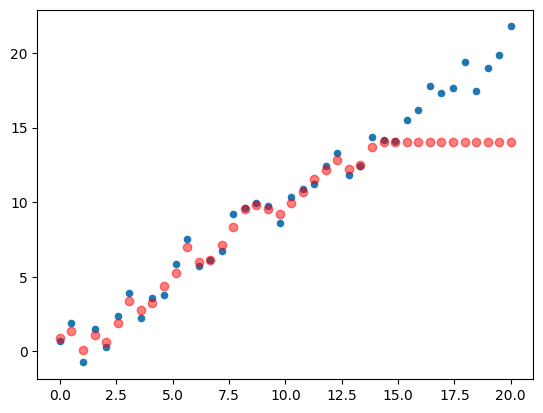

In [5]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

Hence we see that random forests cannot extrapolate in a regression task.

So now we want to figure out what data isn't in-range of our training data, and in particular, if our validation set is identically distributed. We can train a model for that, e.g. on predicting if a row is in the validation set or the training set.

In [6]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)



After training the model, we get the feature importances for the model, which are the ones that are most different between train and valid.

In [7]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')
y_final = load_pickle(path/'y_final.pkl')
valid_y_final = load_pickle(path/'valid_y_final.pkl')
dep_var = 'SalePrice'
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
pd.DataFrame({ 'cols': df_dom.columns, 'imp': m.feature_importances_ }).sort_values('imp', ascending=False)


,cols,imp
5,saleElapsed,0.694222
11,saleYear,0.235588
10,SalesID,0.059384
12,MachineID,0.009867
0,YearMade,0.000358
3,fiProductClassDesc,0.000125
16,Hydraulics,0.000113
8,fiModelDesc,0.000091
15,Tire_Size,0.000078
4,ModelID,0.000069


In [8]:
m = rf(xs_final, y_final)

def r_mse(x, y):
    return round(math.sqrt(((x - y)**2).mean()), 6)

print('orig', r_mse(m.predict(valid_xs_final), valid_y_final))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c,axis=1), y_final)
    print(c, r_mse(m.predict(valid_xs_final.drop(c,axis=1)), valid_y_final))


orig 0.231943
SalesID 0.231436
saleElapsed 0.231423
MachineID 0.23019


We remove `SalesID` and `MachineID` since it looks like they are just correlated with time.

In [9]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y_final)
r_mse(m.predict(valid_xs_time), valid_y_final)


0.229318

We thus hope that the model that is learned without these features is more robust over (extrapolated) time.
We save this choice of columns for the next notebook.

In [10]:
save_pickle(path/'xs_final_time.pkl', xs_final_time)
save_pickle(path/'valid_xs_time.pkl', valid_xs_time)

Alternatively, we may think that significantly old data is useless at helpong us predict very near future points.

<Axes: >

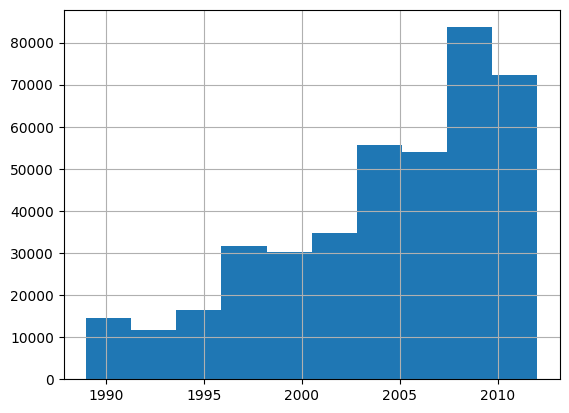

In [11]:
to = load_pickle(path/'to.pkl')
to.train.xs['saleYear'].hist()


Let us see what happens if we train only on more recent data.

In [12]:
filt = to.train.xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = to.train.y[filt]

In [13]:
m = rf(xs_filt, y_filt)
r_mse(m.predict(xs_filt), y_filt), r_mse(m.predict(valid_xs_time), valid_y_final)

(0.174617, 0.230171)

In [14]:
save_pickle(path/'xs_filt.pkl', xs_filt)
save_pickle(path/'y_filt.pkl', y_filt)